# Zero-shot integration tutorial with scGPT

## Introduction

This tutorial covers the zero-shot integration with continual pre-trained scGPT. This particular workflow works for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT.

Continual pre-trained scGPT offers boosted zero-shot performance than the original scGPT. This is achieved by supervising the model with extra cell type labelling signal during the continual pre-training stage. This tutorial will show how to use the latent space of scGPT to integrate scRNA-seq datasets. We use the `scGPT_CP` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y).

We will use the [scIB](https://www.nature.com/articles/s41592-021-01336-8) pancreas dataset as an example. This dataset is publicly accessible via [here](https://figshare.com/ndownloader/files/24539828). You may place the dataset under `data` directory at the outer level.


The zero-shot integration workflow is as follows:

 1. [Load and pre-process the dataset](#prepare-the-datasets)
    
 2. [Generate scGPT embeddings for each cell](#generate-the-cell-embeddings)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Integration_Continual_Pretraining.ipynb)

In [1]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain

    # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "human_pancreas_norm_complexBatch.h5ad")):
        !wget --content-disposition https://figshare.com/ndownloader/files/24539828 -O $data_dir/human_pancreas_norm_complexBatch.h5ad

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_CP"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1_GROJTzXiAV8HB4imruOTk6PEGuNOcgB?usp=sharing",
            output=model_dir,
        )

## Import scGPT and dependencies

In [2]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("../../save/scGPT_CP")

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("best_of")
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("repetition_penalty")
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/huggingface_hu

## Set up evaluation function

We set up the evaluation function, we mainly compare the integration performance on avgBIO and avgBATCH. Refer to our manuscript for more details.

In [3]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()
    
    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    
    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )
    
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    
    return result_dict

## Prepare the datasets

Load the Pancreas dataset (download it from [here](https://figshare.com/ndownloader/files/24539828)), and we set the columns storing gene name columns, batch key and cell type key (optional, this is for evaluation).

In [4]:
smaple_data_path = '../../data/human_pancreas_norm_complexBatch.h5ad'
adata = sc.read_h5ad(smaple_data_path)

gene_col = "Gene Symbol"
cell_type_key = "celltype"
batch_key = "tech"
N_HVG = 1800

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_io/ut

In [5]:
adata.var[gene_col] = adata.var.index.values

Make a copy of the dataset

In [6]:
org_adata = adata.copy()

Preprocess the dataset and select `N_HVG` highly variable genes for downstream analysis.

In [7]:
# preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Generate the cell embeddings

Now we will generate the cell embeddings for the dataset using `embed_data` function. `embed_data` calculates the cell embedding for each cell with the given scGPT model. The extracted embedding is stored in the `X_scGPT` field of `obsm` in AnnData.

In [8]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scgpt/tasks/cell_emb.py:212: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [


scGPT - INFO - match 1722/1800 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 256/256 [00:05<00:00, 42.94it/s]


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


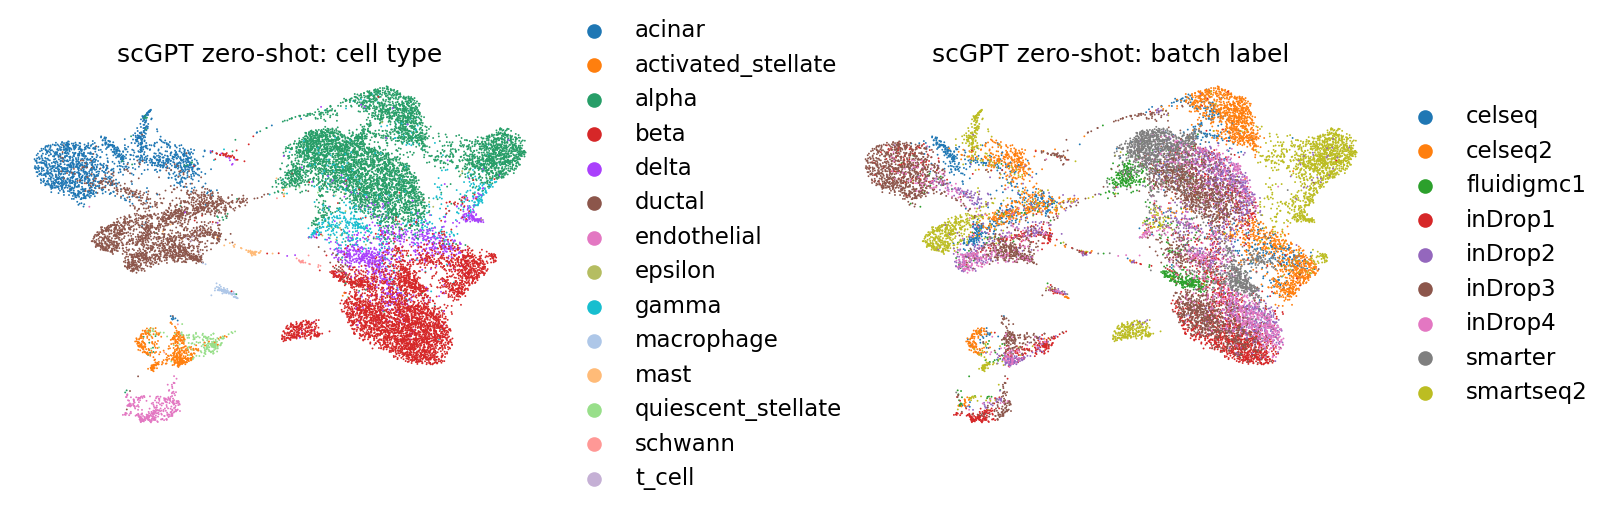

In [9]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: cell type", "scGPT zero-shot: batch label"])

## Evaluate the integration performance

In [10]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...


In [11]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.6541
AvgBATCH: 0.9173


## Comparison with HVG+PCs

We compute the HVG and PCs based on the dataset, this will serve as a baseline for the integration performance.

In [12]:
adata = org_adata.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


UMAP of PCs colored by cell types and batch labels:

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


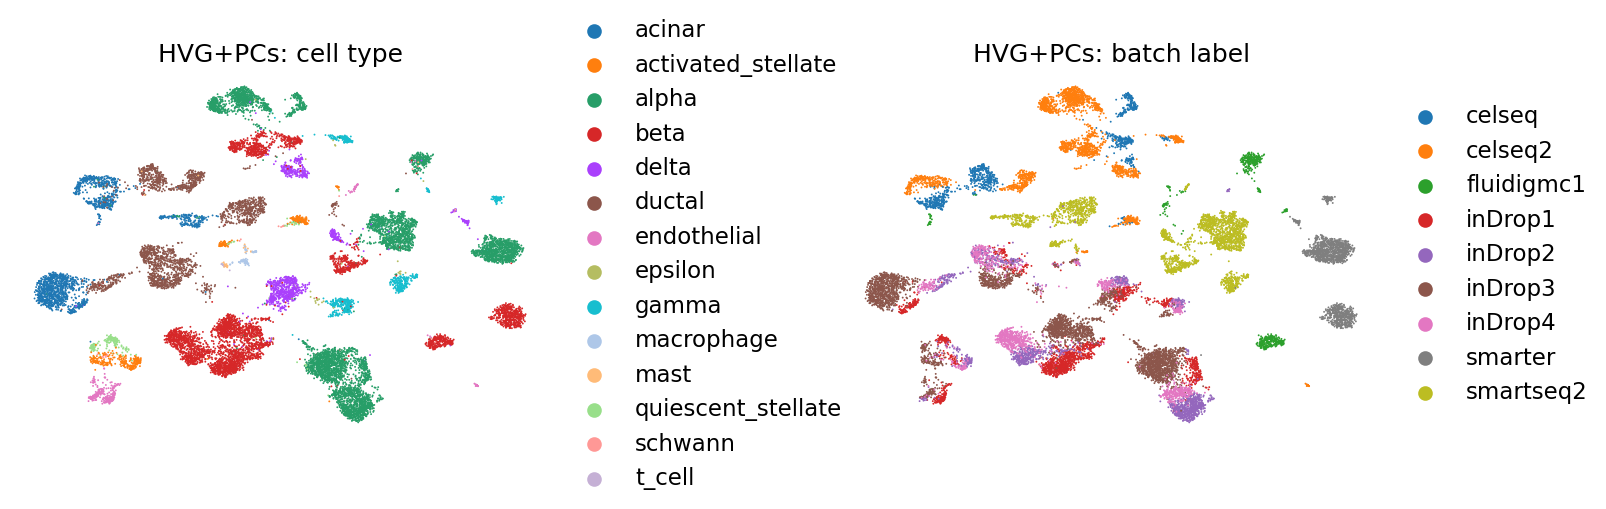

In [13]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["HVG+PCs: cell type", "HVG+PCs: batch label"])

In [14]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...


In [15]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.5398
AvgBATCH: 0.8823
